# Web Scraping for Data Science Course

### Made by: Andrija Botica, Daria Milić, Karlo Nevešćanin
### Professor: dr. sc. Toni Perković

## Introduction

Our idea was to use web scraping to gather data from Croatian stores.

The data can then be used to find the product you want for the cheapest price.

Data will also be used in Human Computer Interaction course where we will implement full-stack web application.

## Getting Started

We used Python, BeautifulSoup and Selenium to scrape data from Croatian stores.

We scraped data from the following stores:
- Konzum - Webshop
- Ribola - Wolt
- Studenac - Wolt
- Tommy - Wolt


To start scraping we need to install the following libraries:
- requests
- bs4
- lxml

In [ ]:
pip install requests bs4 lxml

Now we need to include them in our code (lxml does not need to be included).

In [2]:
import requests
from bs4 import BeautifulSoup

Konzum webshop has different categories of products, so we need to scrape them separately.

Every category has its own URL, so we need to scrape them one by one.

We define a variable `categories` which contains all the categories we want to scrape.
To get each category we will create `categories_links` and `categories_urls` lists.

The latter will have base URL appended to each category link.

In [3]:
# Konzum webshop
URL = "https://www.konzum.hr"

# Variables
categories = []
categories_links = []
categories_urls = []

Now let's scrape the data from Konzum webshop and extract the categories.

In [4]:
r = requests.get(URL)
soup = BeautifulSoup(r.content, "lxml")
table = soup.find("section", attrs={"class": "py-3"})
categories = table.find_all("a", attrs={"class": "category-box__link"})

We will create each categories URL using `for loops`.

In [5]:
for category in categories:
    categories_links.append(category['href'])

for links in categories_links:
    categories_urls.append(URL + links)

To keep count of the number of products we will use `total_products` variable.

In [6]:
total_products = 0

Now we can scrape the data from the categories.

For each category url from `categories_urls` we will scrape the data and extract the product name, price and image alongside with name of the store.

In [ ]:
for category_url in categories_urls:
            page = requests.get(f'{category_url}').text
            pageSoup = BeautifulSoup(page, 'lxml')
            subCategories = pageSoup.find('ul', class_='plain-list mb-3')
            subCategories_aTag = subCategories.find_all('a')

            if subCategories_aTag:
                for aTag in subCategories_aTag:
                    subCategoryLink = aTag.get('href')
                    subCategoryURL = URL + subCategoryLink

                    if subCategoryURL:
                        page_number = 1
                        while True:
                            finalPage = requests.get(f'{subCategoryURL}?page={page_number}')
                            if finalPage.status_code != 200:
                                break
                            finalSoup = BeautifulSoup(finalPage.text, 'lxml')
                            allItems = finalSoup.find('div', class_='col-12 col-md-12 col-lg-10')
                            if not allItems:
                                break

                            productsList = allItems.find('div', class_='product-list product-list--md-5 js-product-layout-container product-list--grid')
                            if not productsList:
                                break

                            articles = productsList.find_all('article', class_='product-item product-default')
                            if not articles:
                                break

                            for article in articles:
                                articleImageURL = article.find('img').get('src')
                                if articleImageURL:
                                    articleTittleTag = article.find('h4', class_='product-default__title')
                                    if articleTittleTag:
                                        articleNameTag = articleTittleTag.find('a', class_='link-to-product')
                                        if articleNameTag:
                                            articleName = articleNameTag.get_text(strip=True)
                                            if articleName:
                                                articleEuro = article.find('span', class_='price--kn').text
                                                articleCent = article.find('span', class_='price--li').text
                                                total_products += 1

                                                print(f'Name: {articleName}', f'Price: {articleEuro}.{articleCent}', f'Image URL: {articleImageURL}', f'Store: Konzum')
                            page_number += 1

print(f'Total number of products: {total_products}')

We have created this code by looking at HTML code of the website. We simply tell BeatifulSoup to find the tags that contain the data we need.

## Selenium

This was just one scraping example. There were other stores that we scraped data from, some of which required use of `Selenium` because of their dynamic content.

Following stores required `Selenium` for scraping due to their dynamic content:
- Ribola - Wolt
- Studenac - Wolt
- Tommy - Wolt


Our scraping code can be found on this link: https://github.com/abotica/data-science-scraping

To start scraping we need to install the following libraries:
- selenium (used for scraping)
- pandas (used for creating dataset)

In [ ]:
pip install selenium pandas

Now we need to include them in our code.

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import pandas as pd
import os
import re

In this example, we will be scraping **Studenac - Wolt**

We will start by opening the Wolt Studenac page using Selenium and handle any pop-ups that may appear.

In [ ]:
WOLT_URL = "https://wolt.com/hr/hrv/split/venue/studenac-kralja-zvonimira-t300/items/"
URL = "https://wolt.com/hr/hrv/split/venue/studenac-kralja-zvonimira-t300"
Store_name = "Wolt-Studenac"
categories_links = []

driver = webdriver.Chrome()
driver.get(URL)

try:
    consent_button = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.CSS_SELECTOR, "div.deorxlo button.cbc_TextButton_rootCss_7cfd4"))
    )
    consent_button.click()
    time.sleep(1)
except Exception as e:
    print(f"Consent button not found or not clickable: {e}")

try:
    x_button = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.CSS_SELECTOR, "button[class='cbc_IconButton_root_7cfd4 c1hmjr97']"))
    )
    x_button.click()
    time.sleep(1) 
except Exception as e:
    print(f"X button not found or not clickable: {e}")

Like above, each store has different categories of products, and almost every category has a few subcategories.

Every subcategory has its own URL, so we need to scrape them one by one.

The following codes show how to get each subcategory's URL, which will then be forwarded to the `scrape_products()` function.

First, we extract the URL of each category on the page and store it in `categories_links`.

Next, we filter these links to remove any irrelevant ones.

In [ ]:
subMenu = driver.find_element(By.CSS_SELECTOR, "div[data-test-id='navigation-bar']")
head_nav_aTag = driver.find_elements(By.CSS_SELECTOR, "a[data-test-id='navigation-bar-link']")
if head_nav_aTag:
    for head_nav in head_nav_aTag:
        categories_links.append(head_nav.get_attribute('href'))

filtered_categories_urls = [url for url in categories_links if "https://wolt.com/hr/hrv/split/venue/studenac-kralja-zvonimira-t300/items/" in url]

For each category URL, we attempt to find subcategories.

If a category has no subcategories, the category URL will be forwarded to the `scrape_products()` function.

If subcategories are present, we extract the URLs of each subcategory and call the `scrape_products()` function for each subcategory.

The `scrape_products()` function is defined in a later cell.

In [ ]:
if filtered_categories_urls:
    for filtered_category_url in filtered_categories_urls:
        page_url = filtered_category_url.replace("https://wolt.com", "")
        a_Tag = driver.find_element(By.XPATH, f'//a[contains(@href, "{page_url}")]')
        a_Tag_parent = a_Tag.find_element(By.XPATH, "./ancestor::div[1]")
        a_Tag.click()
        time.sleep(1)
        temporary = a_Tag_parent.find_element(By.XPATH, "./ancestor::div[1]")
        if 'a1qapeeb rljt8w0' in temporary.get_attribute('class'):
            subpage_divs = a_Tag_parent.find_elements(By.XPATH, "./following-sibling::div[1]//a[@data-test-id='navigation-bar-link']")
            if subpage_divs:
                for subpage_div in subpage_divs:
                    subpage_url = subpage_div.get_attribute('href')
                    subcategory_name = subpage_div.find_element(By.XPATH, "./div[@data-test-id='NavigationListItem-title']")
                    # scrape_products(subpage_url, subcategory_name.text, Store_name)
            else:
                print("Error with getting a tags")
        else:
            category_name =  a_Tag.find_element(By.XPATH, "./div[@data-test-id='NavigationListItem-title']")
            # scrape_products(filtered_category_url, category_name.text, Store_name)
            print("Else")

        driver.execute_script("arguments[0].scrollIntoView({ block: 'start', inline: 'nearest'});", a_Tag_parent)
        time.sleep(1)

Now we can scrape the data from the (sub)categories using the `scrape_products()` function.

First, we handle any pop-ups that may appear.

Then, we start scraping the data (product name, product price, product image URL) from dynamically loaded products. Since they are dynamically loaded, scrolling is needed in order to load all the products.
 
 The script scrolls to the product that is following the last scraped product to ensure all products are loaded and their data is captured, and it continues to scroll until all products of the page are scraped.


Once all products have been scraped, the data is stored in a CSV file. This CSV file will later be used for analysis.

The data is appended to the CSV file if it already exists, ensuring that all scraped data from different categories and stores is consolidated into a single file. This approach allows for easy data manipulation and analysis in subsequent steps.

In [ ]:
def scrape_products(url, cat_name, Store_Name):

    driver = webdriver.Chrome()
    driver.get(url)
    product_list = []
    previous_length = 0
    visited_pages = set()

    print(f'Wep page: {url}')
    try:
        consent_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, "div.deorxlo button.cbc_TextButton_rootCss_7cfd4"))
        )
        consent_button.click()
        time.sleep(1)
    except Exception as e:
        print(f"Consent button not found or not clickable: {e}")

    while True:
        initial_html = driver.page_source
        names_h3 = driver.find_elements(By.CSS_SELECTOR, "[data-test-id='ImageCentricProductCard.Title']")
        seen_products = set([product[0] for product in product_list])
        for name_div in names_h3:
            name = name_div.text.strip()
            if name not in seen_products:
                try:
                    price_div = driver.find_element(By.XPATH, f'//h3[contains(normalize-space(text()), "{name.replace("'", "\'")}")]/../preceding-sibling::div[1]/span')
                    price = price_div.text.strip()
                    if price_div:
                        image_url = price_div.find_element(By.XPATH, "./../../preceding-sibling::div[1]/span/img").get_attribute('src')
                    else:
                        image_url = ""
                except Exception as e:
                    price = "Price not found"
                product_list.append((name, price, image_url))
                seen_products.add(name)
                

        
        # Find and scroll to the last product element
        if product_list:
            last_product_name = product_list[-1][0].strip().replace("'", "\'")
            element = driver.find_element(By.XPATH, f'//h3[contains(normalize-space(text()), "{last_product_name}")]')
            driver.execute_script("arguments[0].scrollIntoView({ block: 'start', inline: 'nearest'});", element)
            time.sleep(1.5)
        else:
            print("No products found.")
            break

        # Check if new products were loaded
        if len(product_list) == previous_length:
            break
        previous_length = len(product_list)

    
    print(f'Number of products: {len(product_list)}')
    print(product_list)
        
    driver.quit()

    print("\n")

    # Create a pandas DataFrame from the product list
    df = pd.DataFrame(product_list, columns=['Product Name', 'Price', 'ImageURL']) 
    df['PageURL'] = url
    df['Category'] = cat_name
    df['Store'] = Store_Name
    df = df[['Product Name', 'Price', 'Category', 'Store', 'ImageURL', 'PageURL']]

    # Save the DataFrame to a CSV file, appending if the file exists
    file_exists = os.path.isfile('products.csv')
    df.to_csv('products.csv', mode='a', header=not file_exists, index=False)


We have created this code by looking at HTML code of the website. We simply tell Selenium to find the tags that contain the data we need.


## Analysis


After successfully scraping the data we created a CSV file containing the data from all the stores. The main goal is to present an analysis of how prices vary across stores. We have divided the analysis into prices, categories, and stores.

### Basic preparations for handling data from a CSV file.

To read a CSV file using Pandas and understand its structure, you first need to ensure that the Pandas library is installed. Run the following command in your terminal or command prompt:

In [21]:
#pip install pandas

Once Pandas is installed, you can import it and load your CSV file. 
First we will display the first 10 lines of the file, so we can see what the CSV file looks like.

In [ ]:
import pandas as pd

df = pd.read_csv('products.csv')

display(df.head(10))

First, we will convert the "price" column to a numeric value so that we can perform analyses with it.
 Then, we will print the new appearance of our data.

In [ ]:
# Clean and convert the 'Price' column to numeric
df['Price'] = df['Price'].str.replace('€', '').str.replace(',', '.').str.strip()
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# Drop rows with invalid prices (if any)
df = df.dropna(subset=['Price']).reset_index(drop=True)

# Verify the cleaning process
df.info(), df.head()


### Price analysis of all stores

This part organizes the data by stores and calculates key statistics for each store, including the number of products, average price, minimum price, and maximum price. These statistics are then displayed in a table format, accompanied by three bar charts that visually represent the maximum, minimum, and average prices for each store.

In [ ]:

%pip install matplotlib seaborn

import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
sns.set(style="whitegrid")

# Group data by 'Store' and calculate summary statistics
store_stats = df.groupby('Store')['Price'].agg(['count', 'mean', 'min', 'max']).sort_values(by='mean')
store_stats.rename(columns={'count': 'Product Count', 'mean': 'Average Price (€)', 
                            'min': 'Minimum Price (€)', 'max': 'Maximum Price (€)'}, inplace=True)

# Display the summary statistics table
display(store_stats)

# Plot bar plots for Maximum Price, Minimum Price, and Average Price
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Bar plot for Maximum Price
sns.barplot(x=store_stats.index, y='Maximum Price (€)', data=store_stats, ax=axes[0])
axes[0].set_title('Maximum Price by Store')
axes[0].set_xlabel('Store')
axes[0].set_ylabel('Maximum Price (€)')

# Bar plot for Minimum Price
sns.barplot(x=store_stats.index, y='Minimum Price (€)', data=store_stats, ax=axes[1])
axes[1].set_title('Minimum Price by Store')
axes[1].set_xlabel('Store')
axes[1].set_ylabel('Minimum Price (€)')

# Bar plot for Average Price
sns.barplot(x=store_stats.index, y='Average Price (€)', data=store_stats, ax=axes[2])
axes[2].set_title('Average Price by Store')
axes[2].set_xlabel('Store')
axes[2].set_ylabel('Average Price (€)')

plt.tight_layout()
plt.show()

We will find the most expensive product and print its name, price, and store.


In [ ]:
# Pronađi redak s najskupljim proizvodom
najskuplji_proizvod = df.loc[df['Price'].idxmax()]
# Ispiši informacije o najskupljem proizvodu
print(f"Najskuplji proizvod: {najskuplji_proizvod['Product Name']}")
print(f"Trgovina: {najskuplji_proizvod['Store']}")
print(f"Cijena: {najskuplji_proizvod['Price']} €")

The data is grouped by stores to identify the most expensive and the cheapest product in each store.

In [57]:
from IPython.display import display

# Group by 'Store' and find the most expensive and cheapest product for each store
store_extremes = df.groupby('Store').apply(lambda x: pd.Series({
    'Najskuplji proizvod': x.loc[x['Price'].idxmax()]['Product Name'],
    'Cijena najskupljeg proizvoda': x['Price'].max(),
    'Najjeftiniji proizvod': x.loc[x['Price'].idxmin()]['Product Name'],
    'Cijena najjeftinijeg proizvoda': x['Price'].min()
}))


# Display the results in a table format
display(store_extremes)

C:\Users\daria\AppData\Local\Temp\ipykernel_4428\1601808984.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  store_extremes = df.groupby('Store').apply(lambda x: pd.Series({


,Najskuplji proizvod,Cijena najskupljeg proizvoda,Najjeftiniji proizvod,Cijena najjeftinijeg proizvoda
Store,,,,
Konzum,Oral B iO S M10 Punjiva Elekrična zubna četkica,530.89,Morsovci Edukativna knjižica,0.07
Wolt-Ribola,Jar tablete lemon all in one 67 kom,29.35,Dr.Oetker vanilin šećer 8 g,0.21
Wolt-Studenac,Jar Platinum tablete za pranje posuđa 65/1,37.99,Chupa chups bomboni gumeni explosion trešnja 10 g,0.23
Wolt-Tommy,"Zacapa centarrio rum 0,7 l",75.99,Dr.Oetker prašak za pecivo 12 g,0.19


### Category


We will display the total number of categories.

In [79]:
ukupan_broj_kategorija = len(categories)
print(f"Ukupan broj kategorija: {ukupan_broj_kategorija}")

Ukupan broj kategorija: 360


koliko koji ducan im kategorija

C:\Users\daria\AppData\Local\Temp\ipykernel_4428\2583659388.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Store', y='Number of Categories', data=store_category_counts, palette="muted")


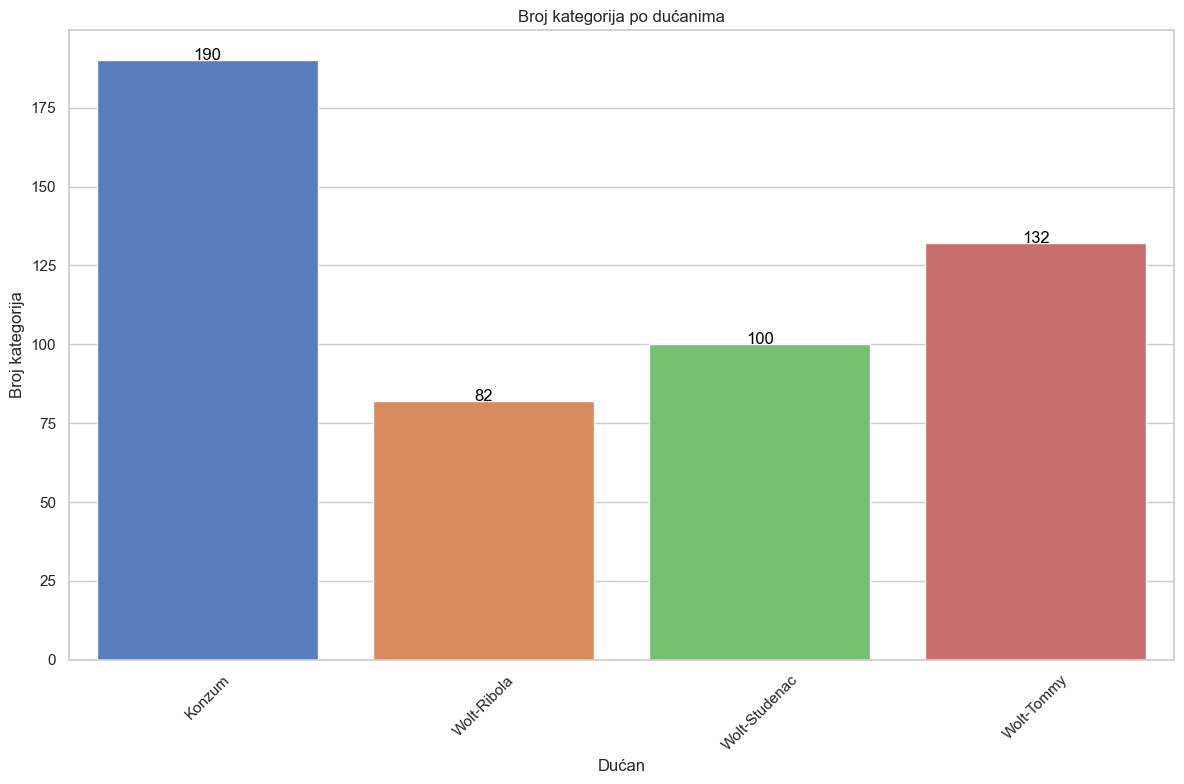

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group by 'Store' and count the number of unique categories for each store
store_category_counts = df.groupby('Store')['Category'].nunique().reset_index()
store_category_counts.columns = ['Store', 'Number of Categories']

# Plot the bar plot
plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(x='Store', y='Number of Categories', data=store_category_counts, palette="muted")

# Add annotations
for index, row in store_category_counts.iterrows():
    bar_plot.text(index, row['Number of Categories'], round(row['Number of Categories'], 2), color='black', ha="center")

plt.title('Broj kategorija po dućanima')
plt.xlabel('Dućan')
plt.ylabel('Broj kategorija')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

 List existing product categories from the CSV file.

In [69]:
categories = df['Category'].unique()
print("Postojeće kategorije proizvoda:")
for category in categories:
    print(category)

Postojeće kategorije proizvoda:
Delimano aparati
Voće
Povrće
Suho voće i povrće, orašasto
Smrznuto voće i povrće
Začinsko bilje
Mlijeko
Sirevi i pripravci
Jaja
Jogurti i ostalo
Vrhnja i pripravci
Mliječni deserti
Margarin, maslac, mast
Namazi
Piletina i puretina
Svinjetina, junetina, ostalo
Riba
Svježi kruh
Pakirani kruh
Dvopek i toast
Tijesta i kvasci
Mlinci i mrvice
Kolači i torte
Mesna delikatesa
Hrenovke i kobasice
Sirevi
Specijaliteti
Plate
Voda
Sokovi i ledeni čajevi
Energetska pića
Pivo
Vino
Alkoholna pića
Voće i povrće
Riba i plodovi mora
Tijesto i pripravci od tijesta
Jela od mesa i povrća
Pizze
Sladoledi i deserti
Žitarice, mahunarke, sjemenke
Dodaci jelima i začini
Riža i tjestenina
Šećer i sladila
Brašno i krupice
Napitci
Voda i sokovi
Kruh
Delikatesa
Muesli, pahuljice, kaše
Keksi
Krekeri
Čokolade i bomboni
Čips, grisini, ostalo
Snackovi
Suho voće i orašasto
Deserti, vrhnja, voćne kašice
Čajevi i kave
Bez grižnje savjesti
Izotonični napitci
Proteini
Energy Boosteri
Superfoo

Analyzing the prices of products in the "Milk" category across different stores and presenting the results in both tabular and graphical formats. The "Milk" category was chosen randomly.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Filter the dataframe for the category 'Mlijeko'
milk_df = df[df['Category'] == 'Mlijeko']

# Group by 'Store' and calculate summary statistics for 'Price'
milk_prices_by_store = milk_df.groupby('Store')['Price'].agg(['count', 'mean', 'min', 'max']).sort_values(by='mean')
milk_prices_by_store.rename(columns={'count': 'Product Count', 'mean': 'Average Price (€)', 
                                     'min': 'Minimum Price (€)', 'max': 'Maximum Price (€)'}, inplace=True)

# Display the summary statistics table
display(milk_prices_by_store)

# Create a grouped bar plot
milk_prices_by_store.reset_index(inplace=True)
milk_prices_by_store_melted = milk_prices_by_store.melt(id_vars='Store', value_vars=['Maximum Price (€)', 'Minimum Price (€)', 'Average Price (€)'], 
                                                        var_name='Price Type', value_name='Price (€)')

plt.figure(figsize=(12, 8))
sns.barplot(data=milk_prices_by_store_melted, x='Store', y='Price (€)', hue='Price Type')

plt.title('Milk Prices by Store')
plt.xlabel('Store')
plt.ylabel('Price (€)')
plt.xticks(rotation=45)
plt.legend(title='Price Type')
plt.tight_layout()
plt.show()

This section analyzes the data to identify the most expensive and the cheapest product categories for each store, presenting the results in both tabular and graphical formats.

In [ ]:
# Group by 'Store' and 'Category' to find the most expensive and cheapest category for each store
category_extremes = df.groupby(['Store', 'Category'])['Price'].agg(['mean']).reset_index()

# Find the most expensive and cheapest category for each store
most_expensive_category = category_extremes.loc[category_extremes.groupby('Store')['mean'].idxmax()]
cheapest_category = category_extremes.loc[category_extremes.groupby('Store')['mean'].idxmin()]

# Merge the results into a single DataFrame
store_category_extremes = pd.merge(most_expensive_category, cheapest_category, on='Store', suffixes=('_most_expensive', '_cheapest'))

# Rename columns for clarity
store_category_extremes.rename(columns={
    'Category_most_expensive': 'Najskuplja kategorija',
    'mean_most_expensive': 'Prosječna cijena najskuplje kategorije (€)',
    'Category_cheapest': 'Najjeftinija kategorija',
    'mean_cheapest': 'Prosječna cijena najjeftinije kategorije (€)'
}, inplace=True)

# Display the results in a table format
display(store_category_extremes)

# Plot the results
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Bar plot for the most expensive category
sns.barplot(data=store_category_extremes, x='Store', y='Prosječna cijena najskuplje kategorije (€)', hue='Najskuplja kategorija', ax=axes[0])
axes[0].set_title('Najskuplja kategorija po dućanu')
axes[0].set_xlabel('Dućan')
axes[0].set_ylabel('Prosječna cijena najskuplje kategorije (€)')
axes[0].legend(title='Najskuplja kategorija', bbox_to_anchor=(1.05, 1), loc='upper left')

# Bar plot for the cheapest category
sns.barplot(data=store_category_extremes, x='Store', y='Prosječna cijena najjeftinije kategorije (€)', hue='Najjeftinija kategorija', ax=axes[1])
axes[1].set_title('Najjeftinija kategorija po dućanu')
axes[1].set_xlabel('Dućan')
axes[1].set_ylabel('Prosječna cijena najjeftinije kategorije (€)')
axes[1].legend(title='Najjeftinija kategorija', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

This section calculates the average price for each category and displays the results. It identifies and prints the most expensive and the cheapest categories along with their average prices. Additionally, it creates a boxplot to show the price distribution for both the most expensive and the cheapest categories.

Category
Party asortiman             0.986111
Izvorska voda               0.989286
Negazirana voda             1.010000
Flips                       1.061000
Brašno, griz i palenta      1.101000
                             ...    
LEGO®                      48.453531
Četkice                    48.941324
Delimano aparati           67.490000
Poklon setovi              76.731579
Električne četkice        114.839259
Name: Price, Length: 360, dtype: float64

Najskuplja kategorija: Električne četkice
Prosječna cijena: 114.84 €
Najjeftinija kategorija: Party asortiman
Prosječna cijena: 0.99 €


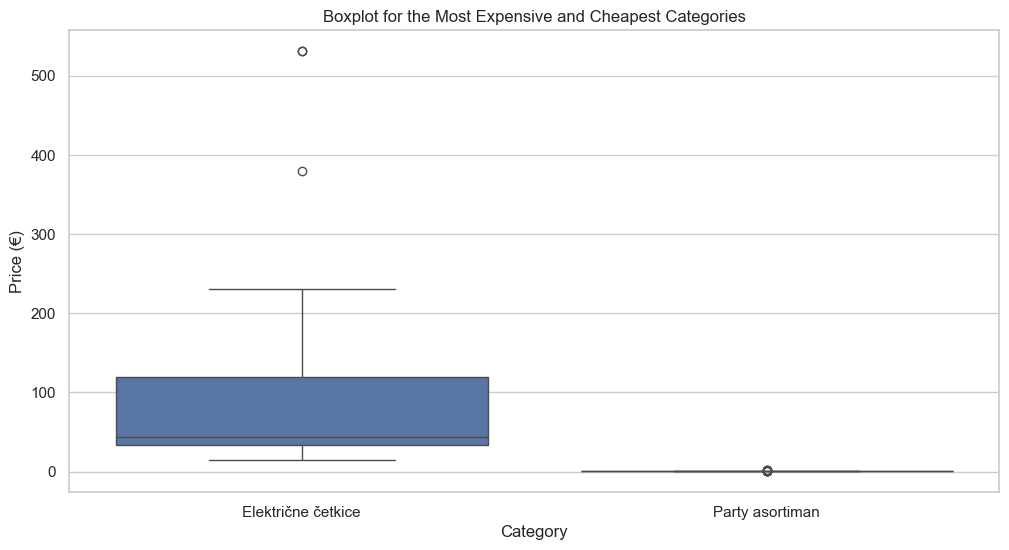

In [74]:
# Calculate the average price for each category
average_price_by_category = df.groupby('Category')['Price'].mean().sort_values()

# Display the average prices
display(average_price_by_category)
# Find the most expensive category
najskuplja_kategorija = average_price_by_category.idxmax()
najskuplja_cijena = average_price_by_category.max()

# Print the most expensive category
print(f"Najskuplja kategorija: {najskuplja_kategorija}")
print(f"Prosječna cijena: {najskuplja_cijena:.2f} €")
# Find the cheapest category
najjeftinija_kategorija = average_price_by_category.idxmin()
najjeftinija_cijena = average_price_by_category.min()

# Print the cheapest category
print(f"Najjeftinija kategorija: {najjeftinija_kategorija}")
print(f"Prosječna cijena: {najjeftinija_cijena:.2f} €")
# Create a boxplot for the most expensive and cheapest categories
plt.figure(figsize=(12, 6))

# Filter the dataframe for the most expensive and cheapest categories
expensive_category_df = df[df['Category'] == najskuplja_kategorija]
cheapest_category_df = df[df['Category'] == najjeftinija_kategorija]

# Combine the two dataframes
combined_df = pd.concat([expensive_category_df, cheapest_category_df])

# Create the boxplot
sns.boxplot(x='Category', y='Price', data=combined_df)
plt.title('Boxplot for the Most Expensive and Cheapest Categories')
plt.xlabel('Category')
plt.ylabel('Price (€)')
plt.show()


This section contains a large amount of data.

It sorts the categories by average price and divides them into pages, each containing 20 categories.
It generates subplots for each page and displays a bar chart of average prices by category. 
Labels are added to highlight the cheapest category on the first page and the most expensive category on the last page.
 A chart is shown for each page.

The goal was to visually display the total categories.


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sort categories by average price
sorted_categories = average_price_by_category.sort_values()

# Define the number of categories per page
categories_per_page = 20

# Calculate the number of pages needed
num_pages = (len(sorted_categories) + categories_per_page - 1) // categories_per_page

# Set the style for the plots
sns.set(style="whitegrid")

# Create subplots for each page
for page in range(num_pages):
    start_idx = page * categories_per_page
    end_idx = min(start_idx + categories_per_page, len(sorted_categories))
    subset = sorted_categories[start_idx:end_idx]
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x=subset.values, y=subset.index, palette="Blues_d")
    plt.title(f'Prosječne cijene po kategorijama (Stranica {page + 1})')
    plt.xlabel('Prosječna cijena (€)')
    plt.ylabel('Kategorija')
    
    # Annotate the cheapest and most expensive categories
    if page == 0:
        plt.annotate('Najjeftinija kategorija', xy=(subset.values[0], 0), xytext=(subset.values[0] + 1, 0),
                     arrowprops=dict(facecolor='black', shrink=0.05))
    if page == num_pages - 1:
        plt.annotate('Najskuplja kategorija', xy=(subset.values[-1], len(subset) - 1), xytext=(subset.values[-1] + 1, len(subset) - 1),
                     arrowprops=dict(facecolor='black', shrink=0.05))
    
    plt.tight_layout()

    plt.show()

This section includes: 
the top 10 categories with the most products.

Calculation the percentage of products for each top category relative to the total number of products.

Printing the number of products and their percentage for each of the top 10 categories.

Ploting a pie chart showing the percentage of products for the top categories, using the defined color palette.

Prikaz broja proizvoda za prvih 10 kategorija u odnosu na ukupni broj proizvoda:
Kategorija: Keksi, Broj proizvoda: 565, Udio: 2.81%
Kategorija: LEGO®, Broj proizvoda: 439, Udio: 2.18%
Kategorija: Začini i mješavine, Broj proizvoda: 373, Udio: 1.86%
Kategorija: Kave, Broj proizvoda: 372, Udio: 1.85%
Kategorija: Sokovi i ledeni čajevi, Broj proizvoda: 324, Udio: 1.61%
Kategorija: Sastojci, Broj proizvoda: 314, Udio: 1.56%
Kategorija: Vino, Broj proizvoda: 292, Udio: 1.45%
Kategorija: Čokolade, Broj proizvoda: 287, Udio: 1.43%
Kategorija: Povrće, Broj proizvoda: 283, Udio: 1.41%
Kategorija: Sredstva za čišćenje, Broj proizvoda: 274, Udio: 1.36%


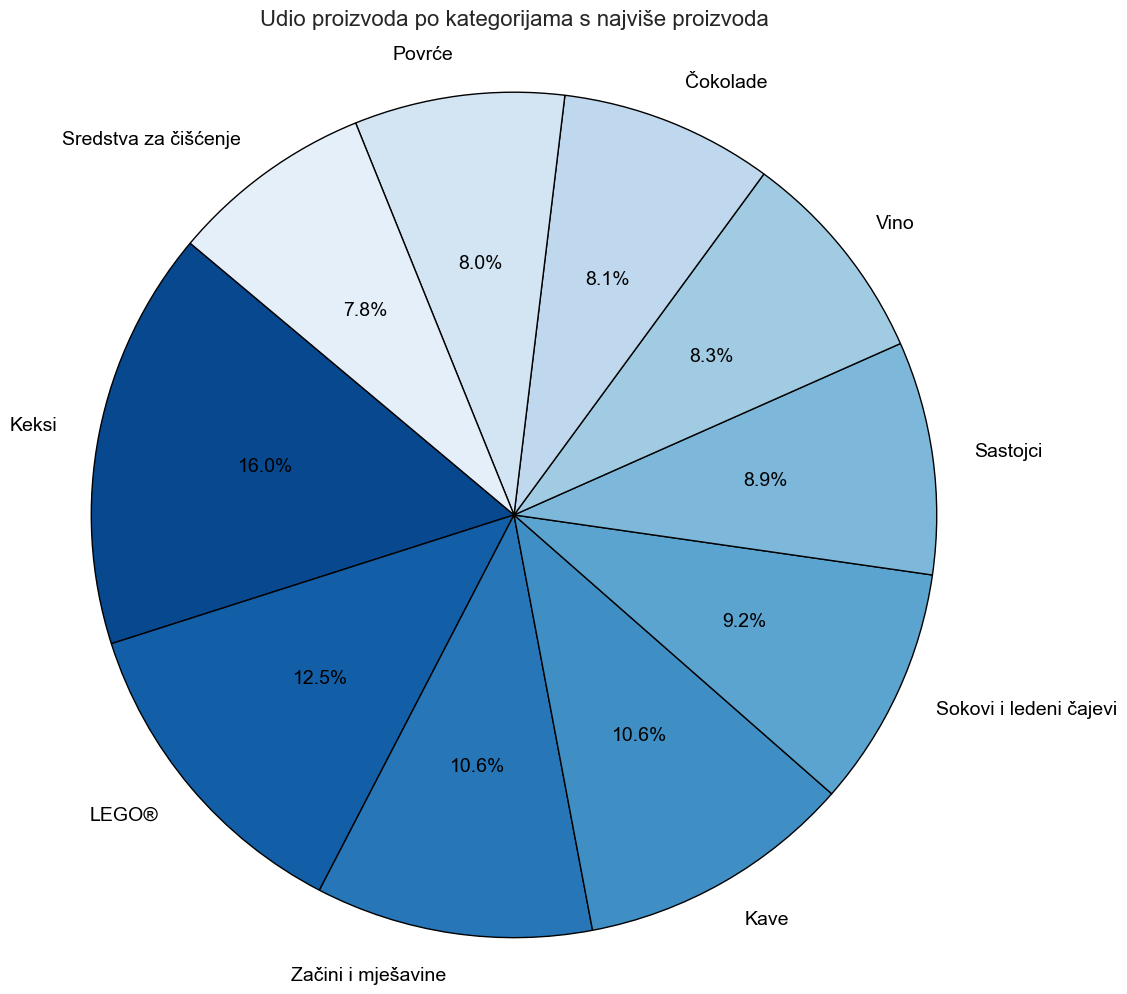

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the top 10 categories with the most products
top_10_categories = category_counts.nlargest(10)

# Calculate the percentage of products for each top category
top_10_category_percentages = (top_10_categories / total_products) * 100

# Print the number of products each top category has in relation to the total number of products
print("Prikaz broja proizvoda za prvih 10 kategorija u odnosu na ukupni broj proizvoda:")
for category, count in top_10_categories.items():
    percentage = top_10_category_percentages[category]
    print(f"Kategorija: {category}, Broj proizvoda: {count}, Udio: {percentage:.2f}%")

# Define a color palette and reverse it
colors = sns.color_palette("Blues", len(top_10_categories))[::-1]

# Plot a pie chart
plt.figure(figsize=(12, 12))
plt.title('Udio proizvoda po kategorijama s najviše proizvoda', pad=20, fontsize=16)
plt.pie(top_10_category_percentages, labels=top_10_categories.index, autopct='%1.1f%%', startangle=140, colors=colors,
        textprops={'fontsize': 14, 'color': 'black'}, wedgeprops={'edgecolor': 'black'})

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Finds categories that are present in all stores.

In [ ]:
common_categories = df.groupby('Category')['Store'].nunique()
common_categories = common_categories[common_categories == df['Store'].nunique()].index.tolist()

print("Kategorije koje se isto zovu u svim dućanima:")
for category in common_categories:
    print(category)



Kategorije koje se isto zovu u svim dućanima:
Energetska pića
Gotova jela
Juhe
Keksi
Mlijeko
Mliječni deserti
Osvježivači prostora
Piletina i puretina
Povrće
Voće
Čokoladni napitci


This part:

Filters the data for categories that are present in all stores. 

Calculates the count of products for each of these common categories.

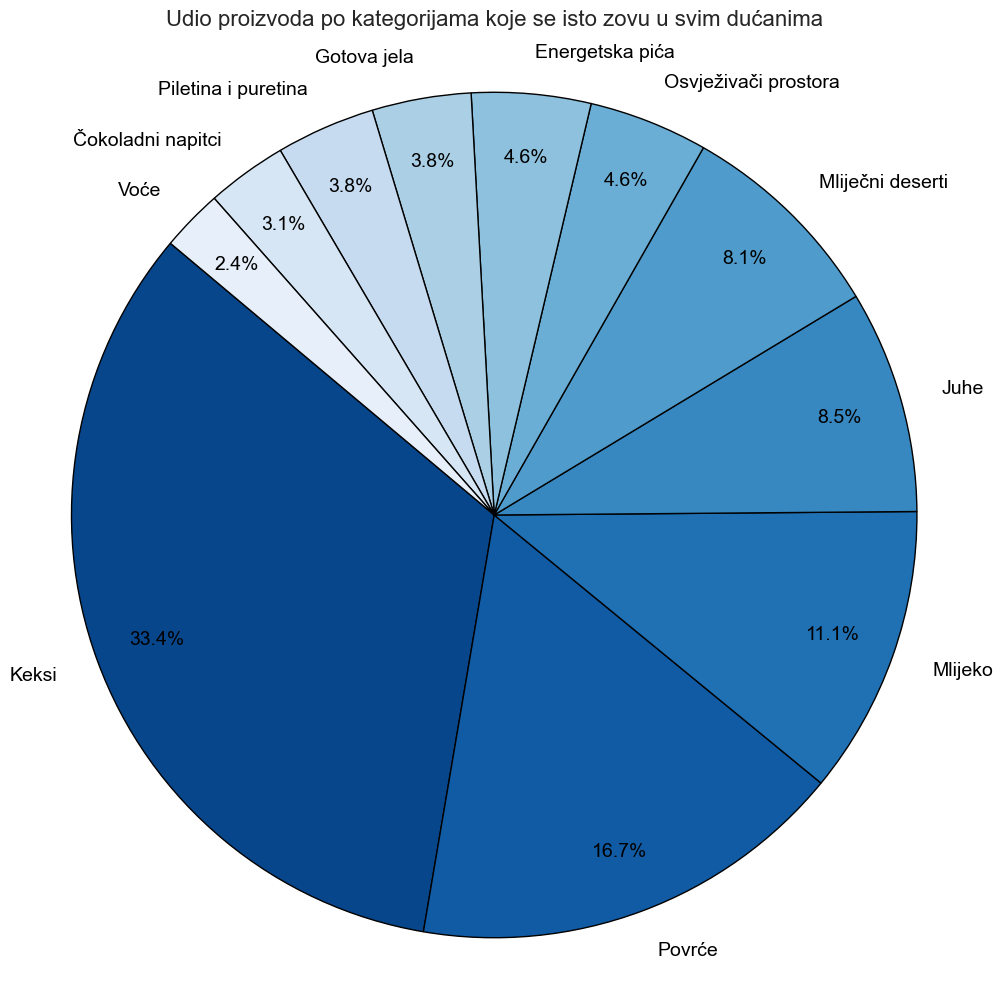

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the dataframe for common categories
common_categories_df = df[df['Category'].isin(common_categories)]

# Calculate the count of products for each common category
common_category_counts = common_categories_df['Category'].value_counts()

# Calculate the percentage of products for each common category
common_category_percentages = (common_category_counts / total_products) * 100

# Define a color palette and reverse it
colors = sns.color_palette("Blues", len(common_category_counts))[::-1]

# Plot a pie chart
plt.figure(figsize=(12, 12))
plt.title('Udio proizvoda po kategorijama koje se isto zovu u svim dućanima', pad=20, fontsize=16)
plt.pie(common_category_percentages, labels=common_category_counts.index, autopct='%1.1f%%', startangle=140, colors=colors,
        textprops={'fontsize': 14, 'color': 'black'}, wedgeprops={'edgecolor': 'black'},
        pctdistance=0.85, labeldistance=1.1)

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


### Stores

This code generates histograms showing the distribution of product prices for each store, with each store's histogram displayed in a separate subplot.

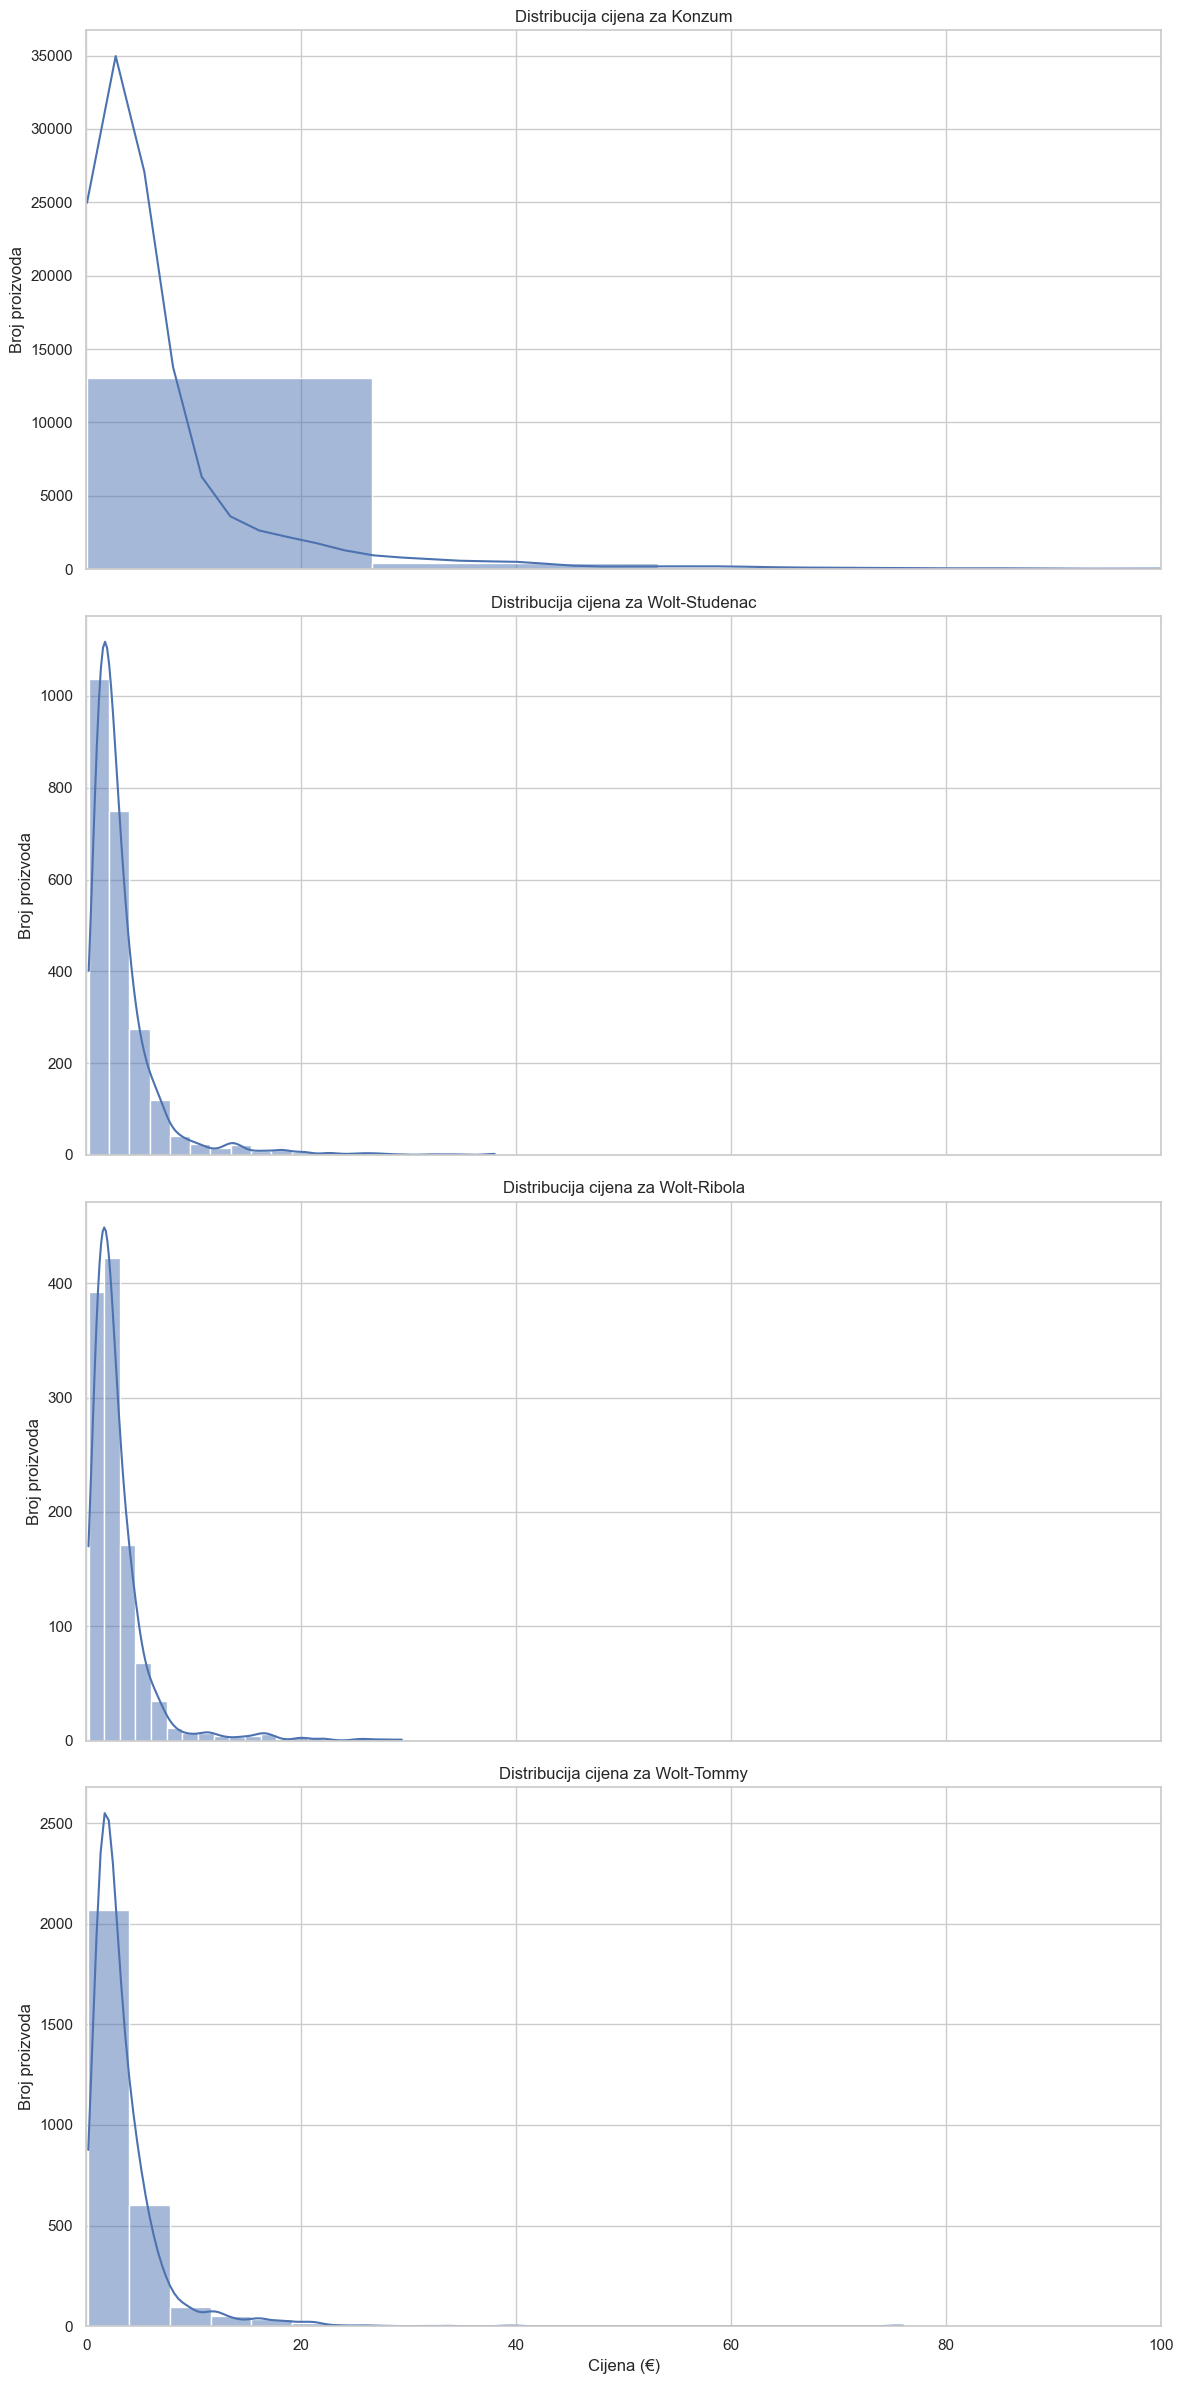

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style for plots
sns.set(style="whitegrid")

# Define the number of bins for the histogram
bins = 20  # Reduced number of bins for better readability

# Create a figure with subplots for each store
stores = df['Store'].unique()
num_stores = len(stores)
fig, axes = plt.subplots(num_stores, 1, figsize=(12, 6 * num_stores), sharex=True)

# Plot histograms for each store
for i, store in enumerate(stores):
    store_df = df[df['Store'] == store]
    sns.histplot(store_df['Price'], bins=bins, kde=True, ax=axes[i])  # Added KDE line
    axes[i].set_title(f'Distribucija cijena za {store}')
    axes[i].set_xlabel('Cijena (€)')
    axes[i].set_ylabel('Broj proizvoda')
    axes[i].set_xlim(0, 100)  # Set x-axis limit to 100

plt.tight_layout()
plt.show()

This code classifies product prices into three categories: rounded, psychological, and other.

<Figure size 1200x800 with 0 Axes>

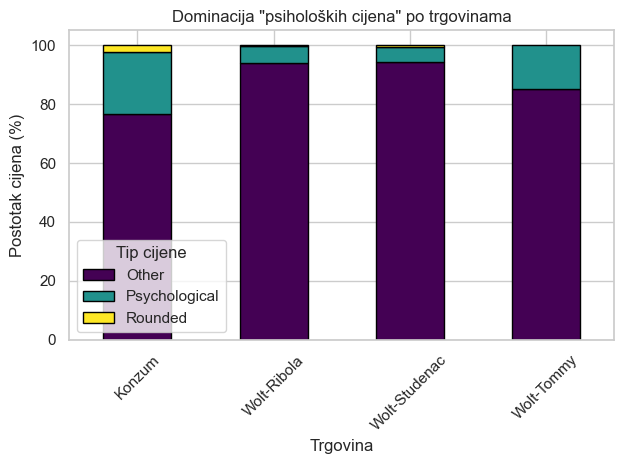

In [54]:
import seaborn as sns

import matplotlib.pyplot as plt

# Define a function to classify prices
def classify_price(price):
    if price % 1 == 0:
        return 'Rounded'
    elif price % 1 >= 0.99:
        return 'Psychological'
    else:
        return 'Other'

# Apply the function to classify prices
df['Price Type'] = df['Price'].apply(classify_price)

# Group by 'Store' and 'Price Type' to count occurrences
price_type_counts = df.groupby(['Store', 'Price Type']).size().unstack(fill_value=0)

# Calculate the percentage of each price type within each store
price_type_percentages = price_type_counts.div(price_type_counts.sum(axis=1), axis=0) * 100

# Plot the results
plt.figure(figsize=(12, 8))
price_type_percentages.plot(kind='bar', stacked=True, colormap='viridis', edgecolor='black')

plt.title('Dominacija "psiholoških cijena" po trgovinama')
plt.xlabel('Trgovina')
plt.ylabel('Postotak cijena (%)')
plt.legend(title='Tip cijene')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Group the data by store and count the number of products for each store.

Create a DataFrame showing the number of products per store.

Generate a bar chart that displays the number of products for each store

C:\Users\daria\AppData\Local\Temp\ipykernel_4428\3845075540.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Store', y='Number of Products', data=store_product_counts, palette="viridis")


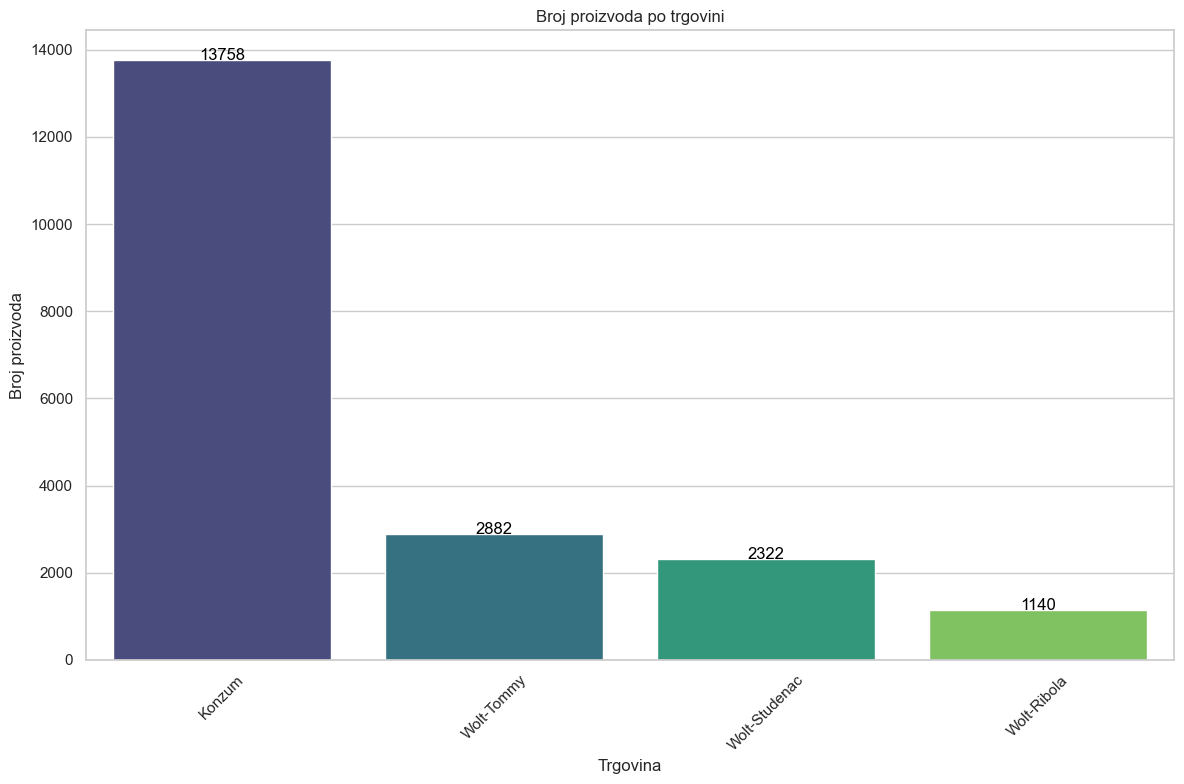

In [82]:
import seaborn as sns

import matplotlib.pyplot as plt

# Group by 'Store' and count the number of products for each store
store_product_counts = df['Store'].value_counts().reset_index()
store_product_counts.columns = ['Store', 'Number of Products']

# Plot the bar plot
plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(x='Store', y='Number of Products', data=store_product_counts, palette="viridis")

# Add annotations
for index, row in store_product_counts.iterrows():
    bar_plot.text(index, row['Number of Products'], round(row['Number of Products'], 2), color='black', ha="center")

plt.title('Broj proizvoda po trgovini')
plt.xlabel('Trgovina')
plt.ylabel('Broj proizvoda')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Group the data by store and find the 5 cheapest products for each store.

C:\Users\daria\AppData\Local\Temp\ipykernel_4428\3205235926.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_5_cheapest_products = df.groupby('Store').apply(lambda x: x.nsmallest(5, 'Price')).reset_index(drop=True)


,Product Name,Price,Store
0,Morsovci Edukativna knjižica,0.07,Konzum
1,Baby Nova Sisači 0-24 mjeseci 2/1,0.10,Konzum
2,Zvjerići 2 Album,0.10,Konzum
3,Rekord Ekološka spužvasta krpa u roli 12/1,0.10,Konzum
4,Barcaffe Black 'n' Easy Mješavina mljevene kav...,0.20,Konzum
5,Dr.Oetker vanilin šećer 8 g,0.21,Wolt-Ribola
6,Dr.Oetker prašak za pecivo 12 g,0.21,Wolt-Ribola
7,Origano Ultra 10g,0.33,Wolt-Ribola
8,Brel Abrazivna Spužvica 1/1,0.33,Wolt-Ribola
9,Nescafe 3u1 strong 14g 28/1,0.36,Wolt-Ribola


C:\Users\daria\AppData\Local\Temp\ipykernel_4428\3205235926.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Price', y='Product Name', data=store_df, ax=axes[i], palette="viridis", orient='h')
C:\Users\daria\AppData\Local\Temp\ipykernel_4428\3205235926.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Price', y='Product Name', data=store_df, ax=axes[i], palette="viridis", orient='h')
C:\Users\daria\AppData\Local\Temp\ipykernel_4428\3205235926.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Price', y='Product Name', data=

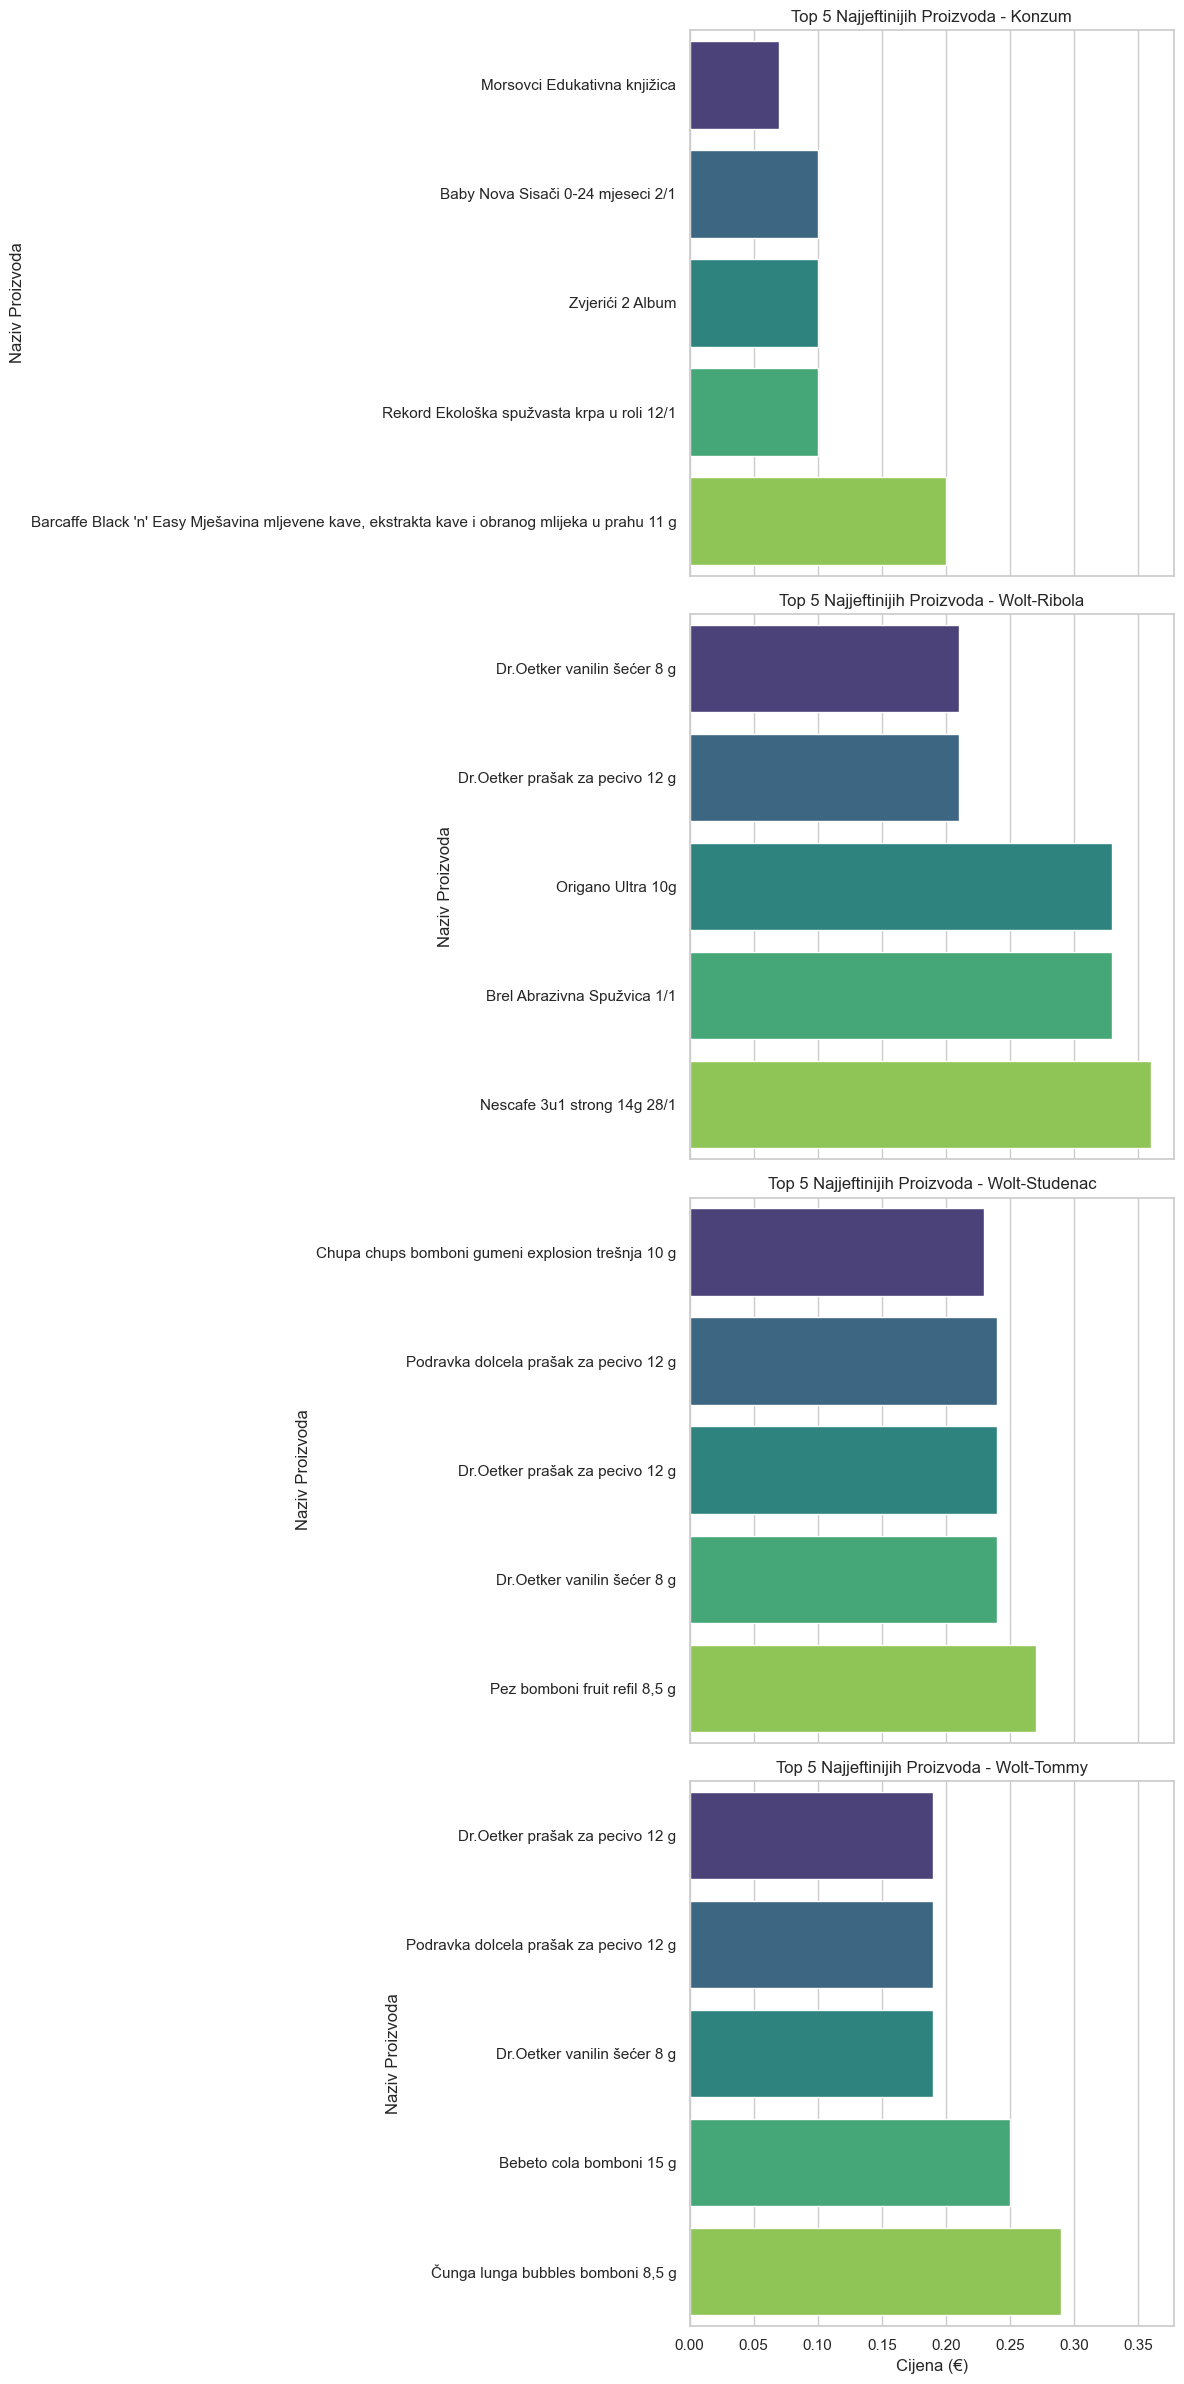

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group the dataframe by 'Store' and find the top 5 cheapest products for each store
top_5_cheapest_products = df.groupby('Store').apply(lambda x: x.nsmallest(5, 'Price')).reset_index(drop=True)

# Select only the relevant columns
top_5_cheapest_products_table = top_5_cheapest_products[['Product Name', 'Price', 'Store']]

# Display the results in a table format
display(top_5_cheapest_products_table)

# Set style for plots
sns.set(style="whitegrid")

# Create a figure with subplots for each store
stores = top_5_cheapest_products['Store'].unique()
num_stores = len(stores)
fig, axes = plt.subplots(num_stores, 1, figsize=(12, 6 * num_stores), sharex=True)

# Plot horizontal bar plots for each store
for i, store in enumerate(stores):
    store_df = top_5_cheapest_products[top_5_cheapest_products['Store'] == store]
    sns.barplot(x='Price', y='Product Name', data=store_df, ax=axes[i], palette="viridis", orient='h')
    axes[i].set_title(f'Top 5 Najjeftinijih Proizvoda - {store}')
    axes[i].set_xlabel('Cijena (€)')
    axes[i].set_ylabel('Naziv Proizvoda')

plt.tight_layout()
plt.show()

Group the data by store and find the 5 most expensive products for each store.

C:\Users\daria\AppData\Local\Temp\ipykernel_4428\550188218.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_5_expensive_products = df_unique.groupby('Store').apply(lambda x: x.nlargest(5, 'Price')).reset_index(drop=True)


,Product Name,Price,Store
0,Oral B iO S M10 Punjiva Elekrična zubna četkica,530.89,Konzum
1,Oral B iO S M10 Punjiva Električna zubna četkica,530.89,Konzum
2,Oral B iO Series 9N Black Onyx Punjiva elektri...,379.99,Konzum
3,Johnnie Walker Blue Label Blended Scotch whisk...,339.05,Konzum
4,"Dom Perignon Šampanjac gift box 0,75 l",313.05,Konzum
5,Jar tablete lemon all in one 67 kom,29.35,Wolt-Ribola
6,Bulldog gin 0.7 l,27.50,Wolt-Ribola
7,"Bombay sapphire london dry gin 0,7 l",26.02,Wolt-Ribola
8,Jack Daniels 0.7 l,25.32,Wolt-Ribola
9,Jagermeister 1 l,22.02,Wolt-Ribola


C:\Users\daria\AppData\Local\Temp\ipykernel_4428\550188218.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Price', y='Product Name', data=store_df, ax=axes[i], palette="magma", orient='h')
C:\Users\daria\AppData\Local\Temp\ipykernel_4428\550188218.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Price', y='Product Name', data=store_df, ax=axes[i], palette="magma", orient='h')
C:\Users\daria\AppData\Local\Temp\ipykernel_4428\550188218.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Price', y='Product Name', data=store_d

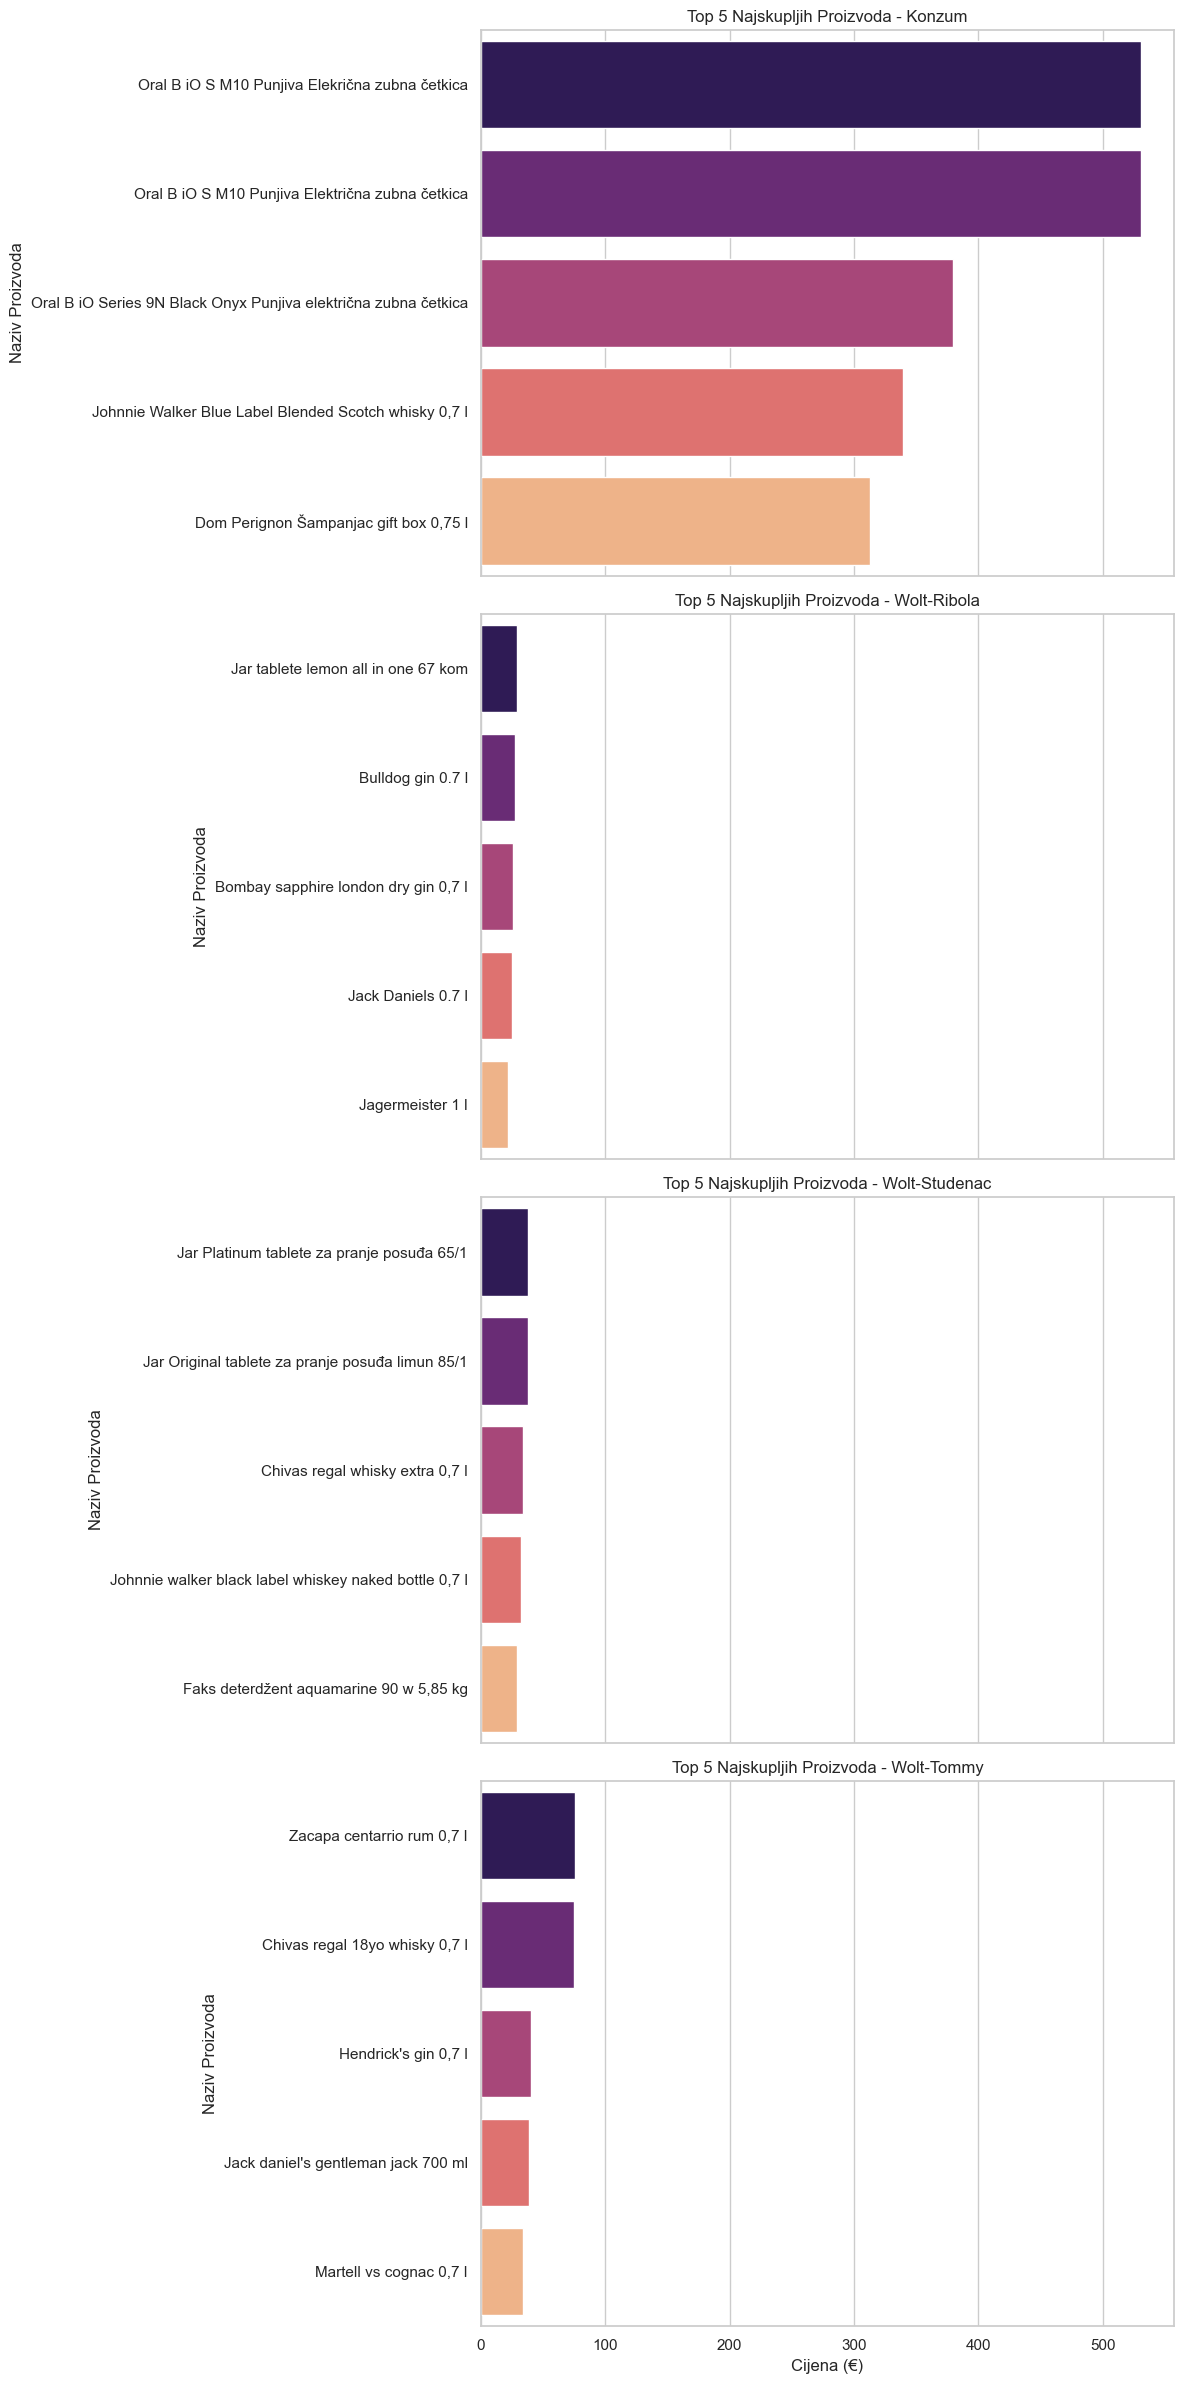

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

# Uklanjanje duplikata po 'Product Name' unutar svake trgovine
df_unique = df.drop_duplicates(subset=['Store', 'Product Name'])

# Grupiranje DataFrame-a po 'Store' i pronalaženje 5 najskupljih proizvoda za svaku trgovinu
top_5_expensive_products = df_unique.groupby('Store').apply(lambda x: x.nlargest(5, 'Price')).reset_index(drop=True)

# Odabir samo relevantnih kolona
top_5_expensive_products_table = top_5_expensive_products[['Product Name', 'Price', 'Store']]

# Prikaz rezultata u tabelarnom formatu
display(top_5_expensive_products_table)

# Postavljanje stila za grafikone
sns.set(style="whitegrid")

# Kreiranje figure sa podgrafikonima za svaku trgovinu
stores = top_5_expensive_products['Store'].unique()
num_stores = len(stores)
fig, axes = plt.subplots(num_stores, 1, figsize=(12, 6 * num_stores), sharex=True)

# Crtanje horizontalnih stubičastih grafikona za svaku trgovinu
for i, store in enumerate(stores):
    store_df = top_5_expensive_products[top_5_expensive_products['Store'] == store]
    sns.barplot(x='Price', y='Product Name', data=store_df, ax=axes[i], palette="magma", orient='h')
    axes[i].set_title(f'Top 5 Najskupljih Proizvoda - {store}')
    axes[i].set_xlabel('Cijena (€)')
    axes[i].set_ylabel('Naziv Proizvoda')

plt.tight_layout()
plt.show()
